In [14]:
#imports
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
import dateutil

In [15]:
LIST_OF_COMPANIES_WIKI = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
website_url = requests.get(LIST_OF_COMPANIES_WIKI).text
soup = BeautifulSoup(website_url, "html.parser")
my_table = soup.find('table',{'class':'wikitable sortable', 'id': "constituents"})
label_items = my_table.findAll('a', {'class': 'external text', 'rel': 'nofollow'})
labels = []
for label_item in label_items:
    label = label_item.get_text()
    if label == 'reports' or label == 'Aptiv Plc':
        continue
    labels.append(label)
print(labels)

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CDW', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CO

In [16]:
# Globals

INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [17]:
# Importing the training set
ticker = yf.Ticker(labels[0])
training_set = ticker.history(period="max")
#load data into dataframe
training_set = training_set.drop(['Dividends', 'Stock Splits', 'High', 'Low', 'Close','Volume'], axis = 1)
#filter data after the last recession
training_set=training_set[training_set.index>dateutil.parser.parse("2009-06-01")]
print(training_set.shape)

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled)

(2632, 1)
[[0.00718961]
 [0.00842919]
 [0.00852836]
 ...
 [0.64721341]
 [0.63690004]
 [0.62628917]]


In [18]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).cuda()
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hidden_state = None

In [19]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float()).cuda()
    labels = Variable(torch.from_numpy(y_train).float()).cuda()

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.2188149243593216
epoch 1, loss 0.17342160642147064
epoch 2, loss 0.13130979239940643
epoch 3, loss 0.09162130206823349
epoch 4, loss 0.055280692875385284
epoch 5, loss 0.025460831820964813
epoch 6, loss 0.00793835986405611
epoch 7, loss 0.009726786985993385
epoch 8, loss 0.027134403586387634
epoch 9, loss 0.03676504269242287
epoch 10, loss 0.0329815112054348
epoch 11, loss 0.02313782460987568
epoch 12, loss 0.013953632675111294
epoch 13, loss 0.008507105521857738
epoch 14, loss 0.006958305835723877
epoch 15, loss 0.008048268035054207
epoch 16, loss 0.010255498811602592
epoch 17, loss 0.012376299127936363
epoch 18, loss 0.013686302118003368
epoch 19, loss 0.013894932344555855
epoch 20, loss 0.013034375384449959
epoch 21, loss 0.011350554414093494
epoch 22, loss 0.009213696233928204
epoch 23, loss 0.007042250595986843
epoch 24, loss 0.0052294423803687096
epoch 25, loss 0.004066726192831993
epoch 26, loss 0.0036708794068545103
epoch 27, loss 0.003938134294003248
epoch 28, 

In [21]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((training_set['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(INPUT_SIZE, 80):
    X_test.append(inputs[i-INPUT_SIZE:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float()).cuda()
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().cpu().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

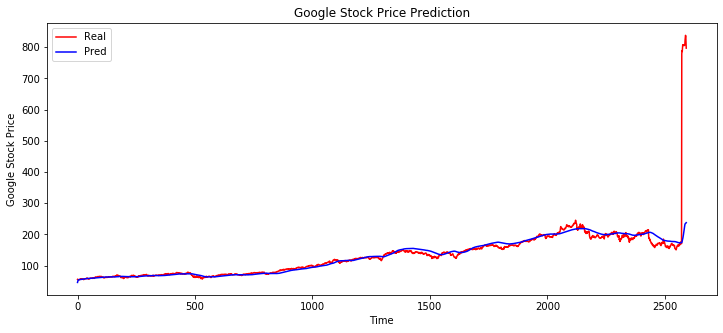

In [22]:
# Visualising the results
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price_all, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()